In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import japanize_matplotlib
from pathlib import Path

# 現在のノートブックからの相対パスを絶対パスに変換
notebook_dir = Path(os.path.abspath('')).parent
data_path = notebook_dir / 'data' / 'processed' / 'wt262avs.adicht_rec2.parquet'

# データの読み込み
df = pd.read_parquet(data_path)

# データの先頭を表示
print("DataFrameの先頭5行:")
display(df.head())

# データの基本情報を表示
print("\nDataFrameの基本情報:")
display(df.info())

DataFrameの先頭5行:


,PFC,PPC,A1,V1,Stimulus,Time_s,PFC_filtered,PPC_filtered,A1_filtered,V1_filtered,Event_ID,Stimulus_Type
0,63.68750,-48.06250,-76.906250,-55.328125,-0.000312,0.000,-9.687126,-29.744644,-29.668319,-31.102712,0,No_Stimulus
1,42.40625,-50.87500,-80.546875,-57.750000,-0.000312,0.001,-16.177164,-31.208505,-31.960842,-31.552850,0,No_Stimulus
2,31.43750,-70.71875,-99.937500,-82.546875,-0.000312,0.002,-22.393838,-32.559073,-34.101970,-31.901094,0,No_Stimulus
3,30.37500,-44.06250,-70.140625,-49.937500,-0.000312,0.003,-28.047092,-33.677845,-35.946312,-32.045870,0,No_Stimulus
4,-4.53125,-58.40625,-88.937500,-58.468750,0.000000,0.004,-32.896286,-34.466580,-37.366260,-31.903339,0,No_Stimulus



DataFrameの基本情報:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240450 entries, 0 to 4240449
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   PFC            float32
 1   PPC            float32
 2   A1             float32
 3   V1             float32
 4   Stimulus       float32
 5   Time_s         float64
 6   PFC_filtered   float64
 7   PPC_filtered   float64
 8   A1_filtered    float64
 9   V1_filtered    float64
 10  Event_ID       int64  
 11  Stimulus_Type  object 
dtypes: float32(5), float64(5), int64(1), object(1)
memory usage: 307.3+ MB


None

In [2]:
import pandas as pd
import numpy as np
import mne

# --- データの準備 ---
# ここにお手元のDataFrameをロードしてください
# 例: df = pd.read_csv('your_data.csv') 

# MNEで扱うための基本情報を設定
sfreq = 1000  # サンプリング周波数 (1000Hz)
ch_names = ['PFC', 'PPC', 'A1', 'V1'] # チャンネル名
ch_types = ['eeg'] * len(ch_names) # チャンネルタイプは全て'eeg'

# MNEのInfoオブジェクトを作成
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 使用するデータを選択 (フィルタリング済みの列)
eeg_data = df[['PFC_filtered', 'PPC_filtered', 'A1_filtered', 'V1_filtered']].T

# MNEのRawオブジェクトを作成 (データはボルト単位にするため 1e-6 をかける)
# 元データがµVの場合を想定
raw = mne.io.RawArray(eeg_data.values * 1e-6, info)

print("MNE Rawオブジェクトが作成されました。")
print(raw)

Creating RawArray with float64 data, n_channels=4, n_times=4240450
    Range : 0 ... 4240449 =      0.000 ...  4240.449 secs
Ready.
MNE Rawオブジェクトが作成されました。
<RawArray | 4 x 4240450 (4240.4 s), ~129.4 MiB, data loaded>


In [4]:
# --- 修正版コード ---
# onsets DataFrameが正しく作成されている前提で開始します
onsets = df[(df['Event_ID'] != 0) & (df['Event_ID'].shift(1) == 0)]

# ステップ1: 新しいシンプルなイベントIDを定義する
# これが最終的にMNEに渡す辞書になります
simple_event_map = {'Light': 1, 'Sound': 2, 'Light+Sound': 3, 'No_Stimulus': 99}

# ステップ2: 元のイベントID（1-1800）から新しいID（1, 2, 3）へ変換する
# まず、どのStimulus_Typeがどの新しいIDに対応するかを紐付けます
type_to_new_id = onsets['Stimulus_Type'].map(simple_event_map)

# 元のイベント配列を作成
event_samples = onsets.index.values
# ここで、Stimulus_Typeに基づいて変換した新しいID（1, 2, 3）をevent_idsとして使用します
event_ids = type_to_new_id.astype(int).values

# 新しいIDで上書きしたイベント配列を作成
events_remapped = np.array([event_samples, np.zeros_like(event_ids), event_ids]).T

print("イベントIDをシンプルな整数に再マッピングしました。")
print("変換後のイベント配列（先頭5件）:")
print(events_remapped[:5])

# ステップ3: 再マッピングしたイベント配列と、シンプルな辞書を使ってEpochsを作成
tmin, tmax = -0.2, 0.5
baseline = (tmin, 0)

# rawオブジェクトは作成済みとします
epochs = mne.Epochs(raw, events_remapped, event_id=simple_event_map, tmin=tmin, tmax=tmax,
                    baseline=baseline, preload=True,
                    on_missing='warn') # 'No_Stimulus' が辞書に含まれていない場合に警告を出す

print("\n--- 正常に作成されたEpochsオブジェクト ---")
print(epochs)
# No_Stimulusを除いた各カテゴリのイベント数が表示される

イベントIDをシンプルな整数に再マッピングしました。
変換後のイベント配列（先頭5件）:
[[ 7086     0     1]
 [ 8618     0     1]
 [10148     0     1]
 [11664     0     1]
 [13197     0     1]]
Not setting metadata
1801 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1801 events and 701 original time points ...
0 bad epochs dropped

--- 正常に作成されたEpochsオブジェクト ---
<Epochs | 1801 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~38.5 MiB, data loaded,
 'Light': 600
 'Sound': 600
 'Light+Sound': 600
 'No_Stimulus': 1>


In [7]:
# 解析に使用するチャネルを指定
ch_names = ['PFC', 'PPC', 'A1', 'V1']
ch_types = ['eeg'] * len(ch_names) # 全てEEGチャネルとして指定
sfreq = 1000 # サンプリング周波数

# フィルター済みデータをNumpy配列として抽出
# MNEは (n_channels, n_times) の形式を期待するため、転置(.T)する
data = df[[f'{ch}_filtered' for ch in ch_names]].values.T

# MNEのInfoオブジェクト（メタデータ）を作成
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# InfoオブジェクトとデータからRawオブジェクトを作成
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=4, n_times=4240450
    Range : 0 ... 4240449 =      0.000 ...  4240.449 secs
Ready.


In [ ]:
# Stimulus_TypeとEvent_IDの対応辞書を作成
event_id_map = {'Light': 1, 'Sound': 2, 'Light+Sound': 3}

# 'Event_ID'が0でない行をイベントとして抽出
events_df = df[df['Event_ID'] > 0]
sample_indices = events_df.index.values
event_ids = events_df['Event_ID'].values

# MNE形式のイベント配列を作成 (サンプル番号, 0, イベントID)
events = np.array([sample_indices, np.zeros(len(event_ids)), event_ids]).T.astype(int)

In [9]:
# エポックの時間窓を指定 (-1秒から+2秒)
tmin, tmax = -1.0, 2.0

# ベースライン補正の時間窓を指定 (-0.5秒から-0.1秒)
baseline = (-0.5, -0.1)

# Epochsオブジェクトを作成
# event_id_mapで、どのIDがどの刺激に対応するかを定義
# preload=Trueでデータをメモリに読み込む
epochs = mne.Epochs(raw, 
                    events=events, 
                    event_id=event_id_map, 
                    tmin=tmin, 
                    tmax=tmax, 
                    baseline=baseline, 
                    preload=True,
                    reject=None) # 必要に応じてアーティファクト除去設定を追加

print(epochs)

Not setting metadata
1490 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1490 events and 3001 original time points ...
0 bad epochs dropped
<Epochs | 1490 events (all good), -1 – 2 s (baseline -0.5 – -0.1 s), ~136.5 MiB, data loaded,
 'Light': 500
 'Sound': 497
 'Light+Sound': 493>


In [10]:
# 時間周波数解析のパラメータ
freqs = np.arange(4., 40., 1.)  # 解析する周波数範囲 (4-39 Hz)
n_cycles = freqs / 2.  # 周波数に応じてサイクル数を変更 (時間-周波数分解能のバランス)

# 各刺激タイプごとに計算
power_dict = {}
for stim_type in event_id_map.keys():
    power = mne.time_frequency.tfr_morlet(epochs[stim_type], 
                                          freqs=freqs, 
                                          n_cycles=n_cycles, 
                                          use_fft=True,
                                          return_itc=False, # パワーのみ計算
                                          average=True)
    power_dict[stim_type] = power

# 例: 'Light'刺激に対するPFCチャネルの結果を確認
print(power_dict['Light'].ch_names)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
['PFC', 'PPC', 'A1', 'V1']


Applying baseline correction (mode: logratio)


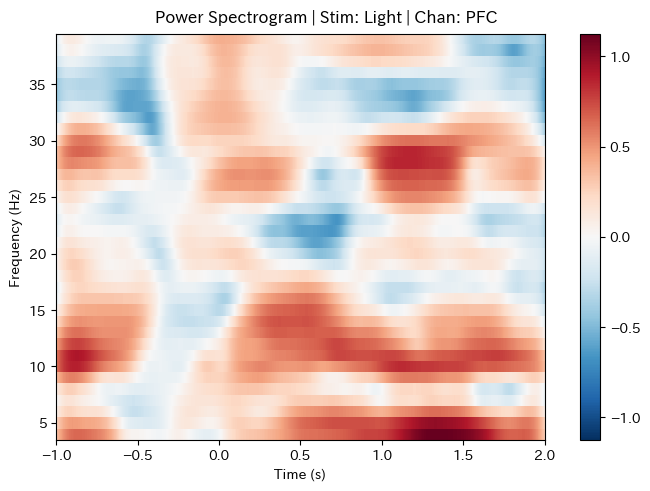

In [11]:
# 'Light'刺激に対するPFCチャネルのパワースペクトログラムをプロット
stim_to_plot = 'Light'
channel_to_plot = 'PFC'

power_dict[stim_to_plot].plot(picks=[channel_to_plot], 
                              baseline=baseline, 
                              mode='logratio', 
                              title=f'Power Spectrogram | Stim: {stim_to_plot} | Chan: {channel_to_plot}');

In [12]:
# 各刺激タイプごとにパワーとITCを同時に計算
power_dict, itc_dict = {}, {}
for stim_type in event_id_map.keys():
    power, itc = mne.time_frequency.tfr_morlet(epochs[stim_type], 
                                               freqs=freqs, 
                                               n_cycles=n_cycles, 
                                               use_fft=True,
                                               return_itc=True, # ITCも計算
                                               average=True)
    power_dict[stim_type] = power
    itc_dict[stim_type] = itc

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


No baseline correction applied


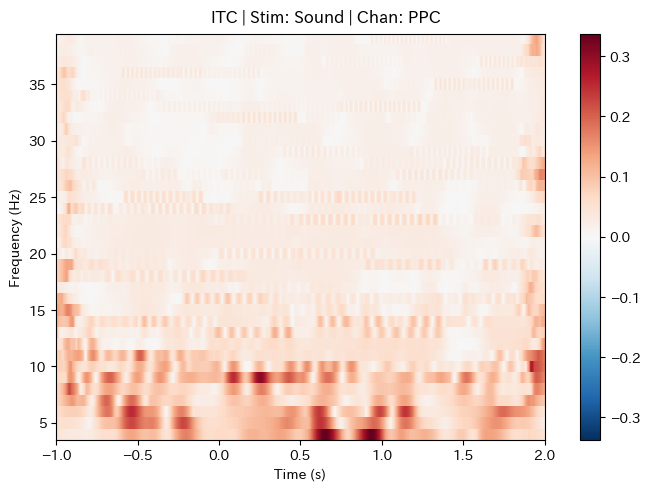

In [13]:
# 'Sound'刺激に対するPPCチャネルのITCをプロット
stim_to_plot = 'Sound'
channel_to_plot = 'PPC'

itc_dict[stim_to_plot].plot(picks=[channel_to_plot], 
                            title=f'ITC | Stim: {stim_to_plot} | Chan: {channel_to_plot}',
                            colorbar=True);